In [1]:
import pandas as pd
import numpy as np
import boto3 

## Load Event Data

In [34]:
bucket_name = 'advanced-ml-project' # Add your bucket name
file_name = 'event.csv'
s3 = boto3.client('s3')
obj = s3.get_object(Bucket=bucket_name, Key=file_name) # S3 uses key-value structure where key is your file name
data = pd.read_csv(obj['Body'])

In [5]:
data.count()

app_id             111946597
session_id         111946597
event              111946597
event_timestamp    111946597
event_value        111946534
user_id_hash       111946597
dtype: int64

## Only Keep Rows with Event Index 8

In [6]:
data.drop(data[data['event'] != '8' ].index , inplace=True);

In [7]:
data.head()

app_id           session_id event  event_timestamp  \
279   4724682771660800  5159335150551901701     8    1541912600211   
2898  4724682771660800   845986603555615931     8    1543357433771   
2970  4724682771660800  2846996524173831068     8    1543023539172   
3002  4724682771660800  6141788581998894012     8    1543531139724   
3597  4724682771660800  6974128812803113234     8    1541437057644   

      event_value                                       user_id_hash  
279         3.493  9943447915df3a45fd6720a026af905b6da6b56a37701b...  
2898        3.493  deaf54103e439789b069a95c4650dc6cdc24d6c9d700f1...  
2970        3.493  deaf54103e439789b069a95c4650dc6cdc24d6c9d700f1...  
3002        1.393  deaf54103e439789b069a95c4650dc6cdc24d6c9d700f1...  
3597        1.393  b2ccdf1ae0d33e2e0a671d605f3fe4cdb72c7fc54bdd49...

In [17]:
print( 'Number of Rows:', len(data))

Number of Rows: 265034


In [18]:
unique_users = len(data['user_id_hash'].unique())
print("Number of Unique Users: ",unique_users)

Number of Unique Users:  34200


In [19]:
data.reset_index(inplace=True, drop=True);

## Save Filtered Event Dataframe

In [21]:
data.to_csv('feature_eng/filtered_events.csv', index=False);

## Load CSV Back into Dataframe - Start From Here if need to rerun stuff!

In [4]:
filtered_events = pd.read_csv('feature_eng/filtered_events.csv')
filtered_events.head()

app_id           session_id  event  event_timestamp  event_value  \
0  4724682771660800  5159335150551901701      8    1541912600211        3.493   
1  4724682771660800   845986603555615931      8    1543357433771        3.493   
2  4724682771660800  2846996524173831068      8    1543023539172        3.493   
3  4724682771660800  6141788581998894012      8    1543531139724        1.393   
4  4724682771660800  6974128812803113234      8    1541437057644        1.393   

                                        user_id_hash  
0  9943447915df3a45fd6720a026af905b6da6b56a37701b...  
1  deaf54103e439789b069a95c4650dc6cdc24d6c9d700f1...  
2  deaf54103e439789b069a95c4650dc6cdc24d6c9d700f1...  
3  deaf54103e439789b069a95c4650dc6cdc24d6c9d700f1...  
4  b2ccdf1ae0d33e2e0a671d605f3fe4cdb72c7fc54bdd49...

## Load Total Users

In [38]:
users = pd.read_csv('feature_eng/train_feature.csv')
users = pd.DataFrame(users['user_id_hash'].unique(), columns= ['user_id_hash'])
print("Number of Total Unique Users in trainset: ", len(users))

Number of Total Unique Users in trainset:  619706


Note that there are way more users we need to predict on than we actually have data for

## Convert UTC Epoch Time to human readable date

In [6]:
filtered_events['event_timestamp'] = pd.to_datetime(filtered_events['event_timestamp'], unit='ms')

In [7]:
filtered_events.head()

app_id           session_id  event         event_timestamp  \
0  4724682771660800  5159335150551901701      8 2018-11-11 05:03:20.211   
1  4724682771660800   845986603555615931      8 2018-11-27 22:23:53.771   
2  4724682771660800  2846996524173831068      8 2018-11-24 01:38:59.172   
3  4724682771660800  6141788581998894012      8 2018-11-29 22:38:59.724   
4  4724682771660800  6974128812803113234      8 2018-11-05 16:57:37.644   

   event_value                                       user_id_hash  
0        3.493  9943447915df3a45fd6720a026af905b6da6b56a37701b...  
1        3.493  deaf54103e439789b069a95c4650dc6cdc24d6c9d700f1...  
2        3.493  deaf54103e439789b069a95c4650dc6cdc24d6c9d700f1...  
3        1.393  deaf54103e439789b069a95c4650dc6cdc24d6c9d700f1...  
4        1.393  b2ccdf1ae0d33e2e0a671d605f3fe4cdb72c7fc54bdd49...

In [8]:
print( "Earliest Date: ", filtered_events.event_timestamp.min())
print( "Latest Date:", filtered_events.event_timestamp.max())

Earliest Date:  2018-10-01 07:35:42.211000
Latest Date: 2018-12-14 23:58:42.037000


## Save Data from Oct 1 - Nov 30 to use in training features

In [29]:
training_set = filtered_events[filtered_events.event_timestamp < '2018-12-01'].copy()
print('Earliest Training Date:', training_set.event_timestamp.min())
print( "Latest Training Date:", training_set.event_timestamp.max())
training_set.to_csv('feature_eng/training_events.csv', index=False);

Earliest Training Date: 2018-10-01 07:35:42.211000
Latest Training Date: 2018-11-30 23:59:42.541000


## Take Data from Dec 1 - Dec 14 to form Training label

In [9]:
label_set = filtered_events[filtered_events.event_timestamp >= '2018-12-01'].copy()

In [11]:
print("Earliest Date:", label_set.event_timestamp.min())
print("Latest Date:", label_set.event_timestamp.max())

Earliest Date: 2018-12-01 00:00:42.221000
Latest Date: 2018-12-14 23:58:42.037000


### Take subset of label_set to get data from Dec 1 through Dec 7

In [12]:
seven_days_data = label_set[label_set.event_timestamp < '2018-12-08'].copy()

In [13]:
print("Earliest Date:", seven_days_data.event_timestamp.min())
print("Latest Date:", seven_days_data.event_timestamp.max())

Earliest Date: 2018-12-01 00:00:42.221000
Latest Date: 2018-12-07 23:59:57.656000


In [15]:
print("Number of Total Unique Users in train label:", len(label_set['user_id_hash'].unique()))
print("Number of Total Unique Users in 7 Day Sub Set:", len(seven_days_data['user_id_hash'].unique()))
print("Number of Total Unique Users in Entire Filtered Events Set:", len(filtered_events['user_id_hash'].unique()))

Number of Total Unique Users in train label: 6126
Number of Total Unique Users in 7 Day Sub Set: 4729
Number of Total Unique Users in Entire Filtered Events Set: 34200


## Add Labels on Train users

In [18]:
seven_days_data = seven_days_data.groupby('user_id_hash', as_index=False)['event_value'].sum()
seven_days_data['user_purchase_binary_7_days'] = seven_days_data['event_value'].apply(lambda x: 1 if x > 0 else 0)
seven_days_data.drop(['event_value'],axis=1, inplace=True)

In [19]:
len(seven_days_data)

4729

In [20]:
fourteen_days_data = label_set.groupby('user_id_hash', as_index=False)['event_value'].sum()
fourteen_days_data['user_purchase_binary_14_days'] = fourteen_days_data['event_value'].apply(lambda x: 1 if x > 0 else 0)
fourteen_days_data.drop(['event_value'],axis=1, inplace=True)

In [21]:
len(fourteen_days_data)

6126

In [22]:
train_labels = pd.merge(users, seven_days_data, how='left', on='user_id_hash')
train_labels = pd.merge(train_labels, fourteen_days_data, how='left', on='user_id_hash')
train_labels.fillna(0, inplace=True)

In [26]:
train_labels.user_purchase_binary_7_days.value_counts()

0.0    614996
1.0      4710
Name: user_purchase_binary_7_days, dtype: int64

In [27]:
train_labels.user_purchase_binary_14_days.value_counts()

0.0    613607
1.0      6099
Name: user_purchase_binary_14_days, dtype: int64

In [61]:
train_labels.to_csv('feature_eng/train_label.csv', index=False);

## Events EDA

In [39]:
import matplotlib.pyplot as plt
%matplotlib inline

In [59]:
x = ['Dec 1 - Dec 14', 'Dec 1 - Dec 7', 'Oct 1 - Dec 1']

In [60]:
counts = [len(fourteen_days_data['user_id_hash'].unique()), 
          len(seven_days_data['user_id_hash'].unique()), 
          len(filtered_events['user_id_hash'].unique())-len(fourteen_days_data['user_id_hash'].unique())]

In [61]:
x_pos = [i for i, _ in enumerate(x)]

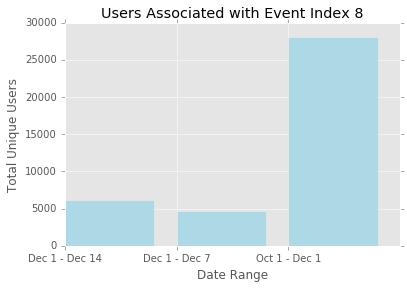

In [69]:
plt.style.use('ggplot')
plt.bar(x_pos, counts, color = 'lightblue')
plt.xlabel("Date Range")
plt.ylabel("Total Unique Users")
plt.xticks(x_pos, x)
plt.title("Users Associated with Event Index 8")
plt.show()

In [71]:
before_dec = filtered_events[filtered_events.event_timestamp < '2018-12-01'].copy()

In [72]:
users_purchased_dec = fourteen_days_data[fourteen_days_data.user_purchase_binary_14_days == 1]['user_id_hash']

In [73]:
users_who_purchased_before = before_dec[before_dec.user_id_hash.isin(users_purchased_dec)].copy()

In [74]:
num_users = len(users_who_purchased_before.user_id_hash.unique())

In [78]:
print("Number of Users purchased on Dec 1- Dec 14 that also purchased (index 8) during Oct and Nov is", num_users)

Number of Users purchased on Dec 1- Dec 14 that also purchased (index 8) during Oct and Nov is 4533


In [81]:
print('Total Number of users who purchased on Dec 1- Dec 14 is', fourteen_days_data.user_purchase_binary_14_days.sum())

Total Number of users who purchased on Dec 1- Dec 14 is 6125


In [82]:
print(round(4533/6125,2), 'percentage of users purchased on Dec 1- Dec 14 have purchased before')

0.74 percentage of users purchased on Dec 1- Dec 14 have purchased before


Thus, we can see whether the user has purchased before is a good indicator of the user's purchase activity.